<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr

from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
wgs_dia_directory = '../sfari/data/diaimmune'

wgs_asd_directory = '../sfari/data/sra_shotgun/Combined'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [2]:
# load 16S, whole genome shotgun dia data
posterior_name = 'age_sex_matched_posterior'
wgs_fname = f'{wgs_dia_directory}/{posterior_name}/wgs_differentials.nc'
wgs_dia_diffs = extract_differentials(wgs_fname)
# load 16S, whole genome shotgun ASD data
posterior_name = 'age_sex_matched_posterior'
wgs_fname = f'{wgs_asd_directory}/{posterior_name}/ogus_differentials-v3.nc'
wgs_asd_diffs = extract_differentials(wgs_fname)

Map GOTU ids to just genome ids

In [3]:
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxonomy, taxid, left_index=True, right_on='GOTU')
lookup = mapping[['GOTU', 'genome']].set_index('GOTU')
wgs_dia_diffs = pd.merge(wgs_dia_diffs.reset_index(), lookup, left_on='features', right_on='GOTU')
wgs_dia_diffs = wgs_dia_diffs.set_index('genome').drop_duplicates()
wgs_dia_diffs = wgs_dia_diffs[~wgs_dia_diffs.index.duplicated(keep='first')]
del wgs_dia_diffs[('features', '')]

/mnt/home/jmorton/miniconda3/envs/catvae/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [22]:
taxa_map = mapping.set_index('genome')

Compute ranking relevant information

In [4]:
# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
wgs_dia_stats = ranking(wgs_dia_diffs, reference_percentile=90)
wgs_asd_stats = ranking(wgs_asd_diffs, reference_percentile=90)

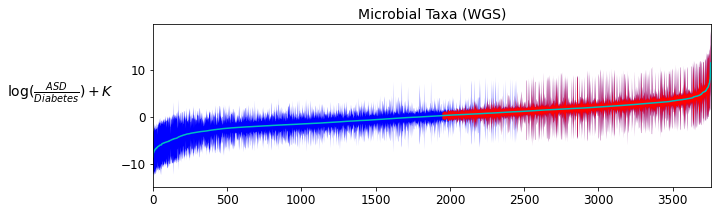

In [17]:
common_taxa = list(set(wgs_dia_diffs.index) & set(wgs_asd_diffs.index))
asd_dia_diffs = wgs_asd_diffs.loc[common_taxa] - wgs_dia_diffs.loc[common_taxa]
asd_dia_stats = ranking(asd_dia_diffs, reference_percentile=50)

fig, ax = plt.subplots(figsize=(10, 3))
fs, ls = 14, 12
rankplot(asd_dia_stats, ax)
ax.set_title('Microbial Taxa (WGS)', fontsize=fs)
#ax.set_ylim([-15, 15])
ax.set_xlim([0, len(asd_dia_stats)])
ax.set_ylabel(r'$\log(\frac{ASD}{Diabetes})+K$', fontsize=fs, labelpad=60)
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)

In [28]:
asd_dia_stats = pd.merge(asd_dia_stats, taxa_map, left_index=True, right_index=True)
asd_dia_stats = asd_dia_stats.sort_values('mean')

In [32]:
asd_dia_stats.to_csv('../results/asd_diabetes_differential.csv')

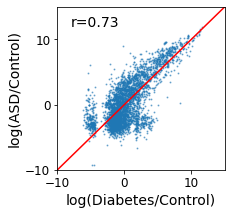

In [9]:
matplotlib.rcParams['text.usetex'] = False

common_wgs_taxa = list(set(wgs_dia_stats.index) & set(wgs_asd_stats.index))
wgs_dia = wgs_dia_stats.loc[common_wgs_taxa]
wgs_asd = wgs_asd_stats.loc[common_wgs_taxa]

fig, ax = plt.subplots(figsize=(3, 3))
y, x = wgs_asd['mean'], wgs_dia['mean']
ax.scatter(x, y, alpha=0.5, s=1)

from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(3)) 
r = pearsonr(x, y)
ax.annotate(f'r={np.round(r[0], 2)}', xy=(-8, 12), fontsize=14)

ax.set_ylabel('log(ASD/Control)', fontsize=14)
ax.set_xlabel('log(Diabetes/Control)', fontsize=14)
ax.set_xlim([-10, 15])
ax.set_ylim([-10, 15])
ax.plot(np.linspace(-10, 15), np.linspace(-10, 15), c='r')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

Compare against IBD

In [10]:
wgs_ibd_directory = '../sfari/data/sra_ibd_shotgun/Combined'

# load 16S, whole genome shotgun IBD data
posterior_name = 'sex_matched_posterior'
wgs_fname = f'{wgs_ibd_directory}/{posterior_name}/wgs_differentials.nc'
wgs_ibd_diffs = extract_differentials(wgs_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
wgs_ibd_stats = ranking(wgs_ibd_diffs, reference_percentile=90)

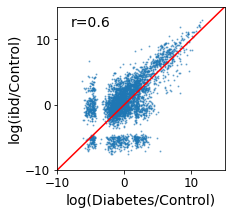

In [11]:
matplotlib.rcParams['text.usetex'] = False

common_wgs_taxa = list(set(wgs_dia_stats.index) & set(wgs_ibd_stats.index))
wgs_dia = wgs_dia_stats.loc[common_wgs_taxa]
wgs_ibd = wgs_ibd_stats.loc[common_wgs_taxa]

fig, ax = plt.subplots(figsize=(3, 3))
y, x = wgs_ibd['mean'], wgs_dia['mean']
ax.scatter(x, y, alpha=0.5, s=1)

from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(3)) 
r = pearsonr(x, y)
ax.annotate(f'r={np.round(r[0], 2)}', xy=(-8, 12), fontsize=14)

ax.set_ylabel('log(ibd/Control)', fontsize=14)
ax.set_xlabel('log(Diabetes/Control)', fontsize=14)
ax.set_xlim([-10, 15])
ax.set_ylim([-10, 15])
ax.plot(np.linspace(-10, 15), np.linspace(-10, 15), c='r')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

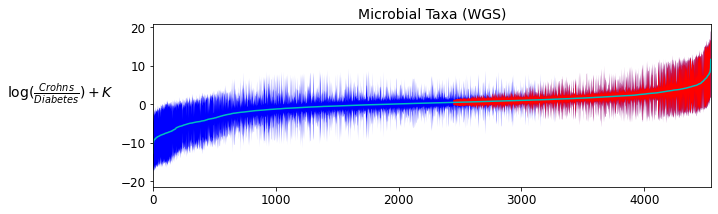

In [18]:
common_taxa = list(set(wgs_dia_diffs.index) & set(wgs_ibd_diffs.index))
ibd_dia_diffs = wgs_ibd_diffs.loc[common_taxa] - wgs_dia_diffs.loc[common_taxa]
ibd_dia_stats = ranking(ibd_dia_diffs, reference_percentile=50)

fig, ax = plt.subplots(figsize=(10, 3))
fs, ls = 14, 12
rankplot(ibd_dia_stats, ax)
ax.set_title('Microbial Taxa (WGS)', fontsize=fs)
#ax.set_ylim([-15, 15])
ax.set_xlim([0, len(ibd_dia_stats)])
ax.set_ylabel(r'$\log(\frac{Crohns}{Diabetes})+K$', fontsize=fs, labelpad=60)
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)

In [26]:
ibd_dia_stats = pd.merge(ibd_dia_stats, taxa_map, left_index=True, right_index=True)
ibd_dia_stats = ibd_dia_stats.sort_values('mean')

In [33]:
ibd_dia_stats.to_csv('../results/ibd_diabetes_differential.csv')